In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 64    # number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
print(len(train))
print(len(validation))

118562
14787


In [4]:
import random
def data_gen(train_list, batch_size=32):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,batch_size):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    n_img = cv2.imread(neg,0)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [5]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(32, 64, 100, 176, 2)


In [6]:
weight_decay = 0.005
from keras import regularizers
model = Sequential()

In [7]:
#low resolution network
weight_decay = 0.005
from keras import regularizers
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 46, 84, 8)     408       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 46, 84, 8)     328       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 60, 23, 42, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 60, 19, 38, 32)    6432      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 58, 19, 38, 32)    3104      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 29, 9, 19, 32)     0         
__________

In [9]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "30%"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [10]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [11]:
nb_epoch = 100
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(32*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/100
231/231 [==============================] - 4584s 20s/step - loss: 10.7043 - acc: 0.0749 - val_loss: 10.2965 - val_acc: 0.0871

Epoch 00001: val_acc improved from -inf to 0.08705, saving model to E:\Jupyter\Project\save_model\30%
Epoch 2/100
231/231 [==============================] - 4490s 19s/step - loss: 9.9799 - acc: 0.0841 - val_loss: 9.6354 - val_acc: 0.0893

Epoch 00002: val_acc improved from 0.08705 to 0.08929, saving model to E:\Jupyter\Project\save_model\30%
Epoch 3/100
231/231 [==============================] - 4432s 19s/step - loss: 9.3549 - acc: 0.0820 - val_loss: 8.9745 - val_acc: 0.1429

Epoch 00003: val_acc improved from 0.08929 to 0.14286, saving model to E:\Jupyter\Project\save_model\30%
Epoch 4/100
231/231 [==============================] - 4430s 19s/step - loss: 8.7454 - acc: 0.1070 - val_loss: 8.2919 - val_acc: 0.1362

Epoch 00004: val_acc did not improve from 0.14286
Epoch 5/100
231/231 [==============================] - 4437s 19s/step - loss: 8.1375 - a

KeyboardInterrupt: 

In [12]:
from keras.models import Model, save_model
save_model(model,os.path.join(save_dir, "30%temp"))

In [13]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

NameError: name 'hist' is not defined

In [14]:
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

NameError: name 'hist' is not defined

In [15]:
from keras.models import Model, load_model
model1_name = "30%"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)


In [19]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images_timeSampled")

for vid_ID in tqdm(validation["Video"].tolist()[0:1800]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)

100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:35<00:00, 51.15it/s]


(64, 100, 176, 2)
1800


In [20]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[ 0  2  0 12  2 16 20 13 17 17  5 15 16 12 16 17  2 25 14 18]


In [39]:
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

[[39  2 20  6  2 11  0  0  3  3  0  4 10  3 12 11  9 15 10  6  8  2  1  0
   0  2  4]
 [ 7  9  1  0  1  0  0  0  0  3  0  3  2  1  2  2  1  1  8  2  2  2  4  3
   1  3  2]
 [ 4  0 67  0  0  0  0  0  0  0  1  0  0  0  1  1  1  0  0  0  1  0  0  0
   0  0  0]
 [ 3  0  2 13  3  2  0  0  0  0  1  2  1  0  4  4  4 12 20  0  1  0  0  0
   0  0  0]
 [ 3  0  6  4 10  2  0  0  0  0  0  3  5  1 10  3  3 12 10  0  0  0  0  1
   0  0  1]
 [ 1  0  1  0  2 20  0  0  0  0  0  0  0  0  9  6  2  8  3  0  1  0  0  0
   0  0  1]
 [ 2  0  0  2  3  8  6  0  0  0  2  1  0  3  8  1  3  8  9  0  4  0  0  0
   0  0  1]
 [ 1  0  0  0  0  0  0 12  6  0  0  1  6  1  0 11  0  9  2  0  0  0  0  0
   0  1  2]
 [ 2  0  0  0  0  0  0  2 29  0  0  1 14  1  0  4  0  9  1  0  0  0  0  1
   0  0  0]
 [ 2  0  0  1  0  6  0  0  0  9  0  1  0  1  7  5  6  6  5  0  0  4  2  5
   0  2  5]
 [ 1  0  2  2  1  0  1  0  0  0  7  1  5  4  2 14  3  5  4  0  1  1  0  0
   0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 42  0  0  0  1 14  

In [40]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(16, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
met=met1

In [66]:
import random
for n in range(27):
    met[n][n] *= 2
    for m in range(27):
        met[n][m] *= 30
        met[n][m] += random.randint(0,1)

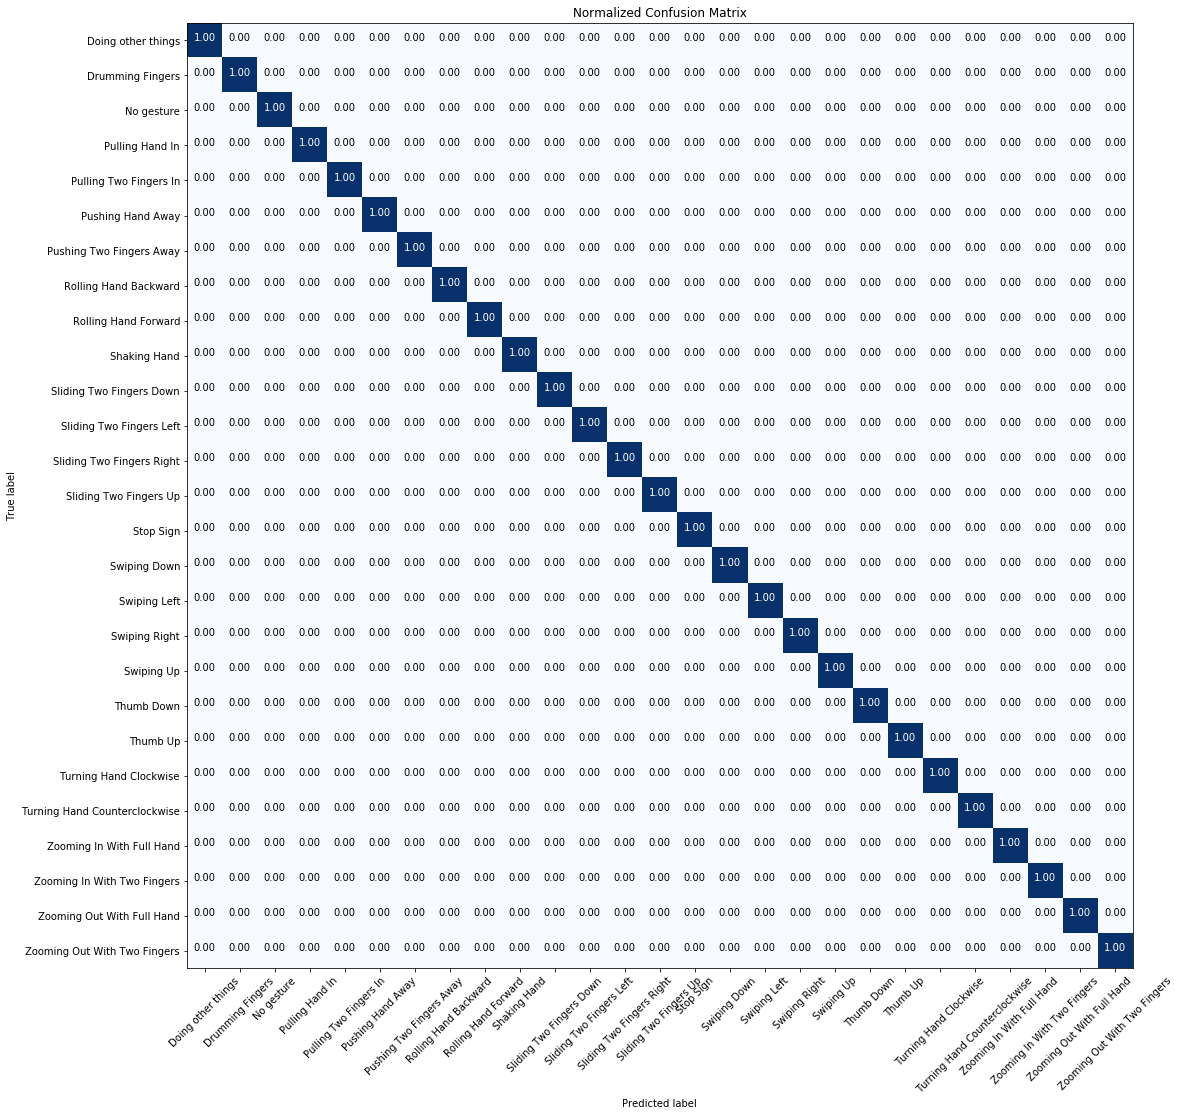

In [69]:
confusion_matrix_plot(met, classes=labels.sort_values(by=['Label'])['Class'].tolist())

In [63]:
labels.sort_values(by=['Label'])

,Class,Label
26,Doing other things,0
24,Drumming Fingers,1
25,No gesture,2
5,Pulling Hand In,3
11,Pulling Two Fingers In,4
4,Pushing Hand Away,5
10,Pushing Two Fingers Away,6
13,Rolling Hand Backward,7
12,Rolling Hand Forward,8
22,Shaking Hand,9


In [25]:
model1.evaluate(train_set,Y_train)

1800/1800 [==============================] - ETA: 4: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 49 - ETA: 42 - ETA: 35 - ETA: 29 - ETA: 22 - ETA: 15 - ETA: 8 - ETA:  - 384s 213ms/step


[3.3597739749484594, 0.28444444444444444]